In [171]:
# implementacion del paper theo2007
# mutual impedanci 2 coils arbitrary position

import pandas as pd
from scipy import integrate
from scipy import special
import numpy as np
import math

# Examples

# Compute the double integral of x * y**2 over the box x ranging from 0 to 2 and y ranging from 0 to 1.

# from scipy import integrate
# f = lambda y, x: x*y**2
# integrate.dblquad(f, 0, 2, lambda x: 0, lambda x: 1)
#     (0.6666666666666667, 7.401486830834377e-15)


lim=1000
frec=100
w=2*np.pi*frec
mu0=1.26e-6

## tabla1
#driver
dr1=7.04e-3
dr2=12.2e-3
dl=5.04e-3
dN=544
dL0=5.55e-6
dn=dN/((dr2 -dr1)*dl)


#pickup
pr1=7.04e-3
pr2=12.40e-3
pl=5.04e-3
pN=556
pL0=5.84e-6
pn=pN/((pr2 -pr1)*pl)

#placa
sigma1=29.4e6
mu1=1
c1=2.47e-3


## config
# driver
dtita=0
dji=0
dx0=0
dy0=0
dl0=3.08e-3

# pickup
ptita=0
pji=math.radians(90)
px0=28e-3
py0=0
pl0=3.1e-3

# r1,r2,l,n,tita,ji,x0,y0,l0=coil

coil_d=[dr1,dr2,dl,dn,dtita,dji,dx0,dy0,dl0]
coil_p=[pr1,pr2,pl,pn,ptita,pji,px0,py0,pl0]


In [173]:


def a(u,v):
    return np.sqrt(u**2+ v**2)

def psi(u,v,tita):
    ps=u*np.sin(tita) + 1j*a(u,v)*np.cos(tita) 

    return ps

def R(u,v):
    a1=a(u,v)
    b1=np.sqrt(a1**2 + 1j*w*mu1*mu0*sigma1)/mu1 
    r=(a1-b1)/(a1+b1)  

    return r


#def I(x1,x2):
#    q=integrate.quad(lambda x: x*special.iv(1,x), x1, x2)[0]
#    return q

def I(x1,x2):
    #la modstruve no acepta complejos
    m=(x1*(special.iv(0,x1)*struvel(1, x1) -special.iv(1,x1)*struvel(0, x1) )-
       x2*(special.iv(0,x2)*struvel(1, x2) - special.iv(1,x2)*struvel(0, x2) ))*np.pi/2
    return float(mp.re(m)) + 1j*float(mp.im(m))

def zum(klen,z1,z2):
    x=[]
    for k in range(0,klen):
        x.append((special.iv(2*k+1,z2)-special.iv(2*k+1,z1))*(-1)**k)
    return np.array(x).sum()

def Is(z1,z2,klen=10):

    y=z2*special.iv(0,z2)-z1*special.iv(0,z1)-zum(klen,z1,z2)
    
    return y

def H(uu,vv,coil):
    r1,r2,l,n,tita,ji,x0,y0,l0=coil
    d= l0 + r2*np.sin(np.abs(tita)) + (l/2)*np.cos(tita)
    
    u=uu*np.cos(ji)+vv*np.sin(ji)
    v=-uu*np.sin(ji)+vv*np.cos(ji)
    
    h=1j*n*Is(psi(u,v,tita)*r1,psi(u,v,tita)*r2)*np.exp(-a(u,v)*d)*np.sin(psi(u,v,tita)*l/2)/psi(u,v,tita)**3


    hp=h*np.exp(1j*uu*x0)*np.exp(1j*vv*y0)

    return hp


def H(uu,vv,coil):
    '''fast H'''
    r1,r2,l,n,tita,ji,x0,y0,l0=coil
    d= l0 + r2*np.sin(np.abs(tita)) + (l/2)*np.cos(tita)
    
    u=uu*np.cos(ji)+vv*np.sin(ji)
    v=-uu*np.sin(ji)+vv*np.cos(ji)
    
    h=1j*n*Is(psi(u,v,tita)*r1,psi(u,v,tita)*r2)*expsin(u,v,d,tita,l)/psi(u,v,tita)**3


    hp=h*np.exp(1j*uu*x0)*np.exp(1j*vv*y0)

    return hp

def expsin(u,v,d,tita,l):
    y=np.exp(1j*psi(u,v,tita)*l/2 - a(u,v)*d)-np.exp(-1j*psi(u,v,tita)*l/2 - a(u,v)*d)
    return y/2j

def int_re(u,v,coil_d,coil_p):
        
    return np.real((a(u,v)**-1)*H(u,v,coil_d)*H(-u,-v,coil_p)*R(u,v))

def int_im(u,v,coil_d,coil_p):
        
    return np.imag((a(u,v)**-1)*H(u,v,coil_d)*H(-u,-v,coil_p)*R(u,v))

def mutual(coil_d,coil_p,frec):
    
    f = lambda v, u: int_re(u,v,coil_d,coil_p)
    w=2*np.pi*frec

    dzn=2*w*mu0*integrate.dblquad(f, 0.1, lim, lambda u: 0.1, lambda u: lim)[0]
    dzp=2*w*mu0*integrate.dblquad(f, -lim, -0.1, lambda u: -lim, lambda u: -0.1)[0]


    return dzn+dzp

In [118]:
fv=np.logspace(2,5,10)
fv

array([   100.        ,    215.443469  ,    464.15888336,   1000.        ,
         2154.43469003,   4641.58883361,  10000.        ,  21544.34690032,
        46415.88833613, 100000.        ])

In [172]:
mutual(coil_d,coil_p,frec)

-3.4115141371614883

In [152]:
M=[]
for f in fv:
    M.append(mutual(coil_d,coil_p,f))

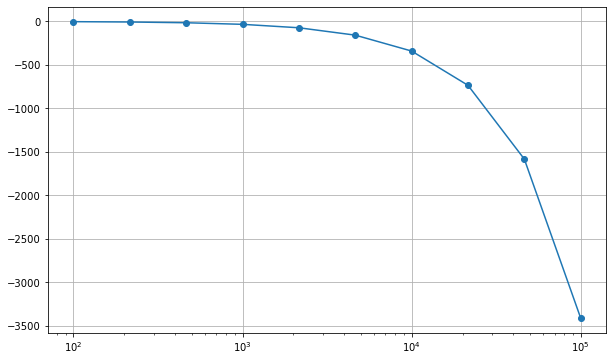

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,6])
plt.semilogx(fv,M,'o-')
plt.grid(True)



In [89]:
special.iv(0,2+1j)

(1.5862594502023712+1.391602452327336j)

In [96]:
type(np.sin(3j+1))

numpy.complex128

In [106]:
float(mp.re(struvel(0, 1+1j))) + 1j*float(mp.im(struvel(0, 1+1j)))


complex

In [163]:
pp=[]
for k in range(0,10):
    pp.append(zum(k,1+1j,2+3j))

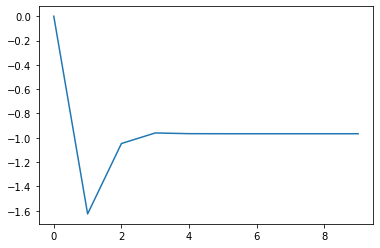

In [164]:
plt.plot(pp)